# Simulation of the Finnish population development

This project provides simplified (=unrealistic) simulation of the Finnish population development. 

Why to simulate population development? In big picture, demographic evolution of a country heavily affects country's long term development in all areas - not just in the country's population itself. Structure and development of the population affects economic development, pension system, health care system and education system just to name few.

Population simulation provides a nice excuse to play with probability distributions and other core concept of probability math and statistics. I have had also an idea of a society simulation game and this works as a sandbox to test one fundamental building block of that idea.

### Simulation lifecycle / algorithm

Basic simulation cycle iterates following steps over time period $\Delta t = 1\ year$:

0. Initialize simulation population $X$ and start simulation loop.
1. Using lifetime (age of death) simulation model check who will die in current iteration (current year) and remove dead from the simulation population.
2. Increase simulation population age by $\Delta t = 1\ year$
3. Using birth simulation model check who will give birth in current iteration (current year) and add newborn babies to the simulation population.
4. Jump back to step 1 until simulation target year has been reached.

Steps 1 and 3 are described in detail in the theory section.

#### Limitations

**Why this simulation is not realistic?** Or why this is not even to some extent inline with official forecasts / models. There are of course a vast number of parameters that affect population development and it is not possible to take into account all of those, but this simulation model lacks with some key components:

1. **Immigration and emigration** has been excluded. Without immigration (as seen in this simulation) and with current fertility rates population development will decrease quite drastically. **This is the main reason for incompatible results**.
2. Risk of death has been assumed to stay in the level of reference year (2020). It would make sense to assume that due to development of health care etc. risk of death distribution could take a slight leap to the right.
3. Fertility rates have been assumed to stay in the level of reference year (2020). Latest fertility rates has increased a bit since reference year 2020.

## Data sources

This simulation initializes itself with official data from [Statistics Finland](https://www.stat.fi/index_en.html).

Initial population distribution of sexes and ages has been generated using following statistics using year 2020:  
StatFin / Population / Population structure / 11rd -- Population according to age (1-year 0-112) and sex, 1972-2021
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__vaerak/statfin_vaerak_pxt_11rd.px/chart/chartViewColumn/

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

Birth rate simulation uses following statistics using year 2020:  
StatFin / Population / Births / 12dm -- Live births by sex, birth order and age of mother (1-year), 1990-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__synt/statfin_synt_pxt_12dm.px/table/tableViewLayout1/

Code uses convention that whenever dataframe / variable name starts with "stats_" it means that it contains official initial fixed data.

## A results sneak peek

![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=7)

## Theory for the simulation

Variables in the model:

$$
\begin{align}
X_{i} & = \textrm{i:th individual in the population} \newline
X_{i,sex} & = \textrm{sex of the i:th individual} \newline
X_{i,age} & = \textrm{age of the i:th individual} \newline
X_{i,year\ of\ birth} & = \textrm{year of birth of the i:th individual} \newline
X_{i,age\ of\ death} & = \textrm{age of death of the i:th individual (populated in simulation)} \newline
T_{year} & = \textrm{(simulation) year}
\end{align}
$$

### Initial population

Initial population population is generated based on age and sex distribution of the 2020 statistics. There is no randomness / sampling in the procedure to create initial population dataframe. Instead, number of people in each age and sex group is used as is.

### Simulation of lifetime

Lifetime simulation uses death risks by age and sex statistics from the year 2020. This simulation **keeps death risk distribution same over the simulation**:

$$
\begin{align}
P(X_i \textrm{ dies}|T_{year}) & = P(X_i \textrm{ dies}|X_{i,sex},X_{i,age},T_{year}=2020) \newline & = P(X_i \textrm{ dies}|X_{i,sex},X_{i,age})
\end{align}
$$

So death risk is modeled as a function (conditional probability) of sex and age of the individual.

### Simulation of giving birth

Giving birth simulation uses births by mother's age statistics from year 2020. This simulation **keeps the birth distribution same over the simulation**:

$$
\begin{align}
P(X_i \textrm{ gives birth}|T_{year}) & = P(X_i \textrm{ gives birth}|X_{i,sex}=1,X_{i,age},T_{year}=2020) \newline
& = P(X_i \textrm{ gives birth}|X_{i,sex},X_{i,age})
\end{align}
$$

Trivially:

$$
\begin{gather}
P(X_i \textrm{ gives birth}|X_{i,sex}=0) = 0
\end{gather}
$$

So birth is modeled as a function (conditional probability) of sex and age of the individual.

#### Simulation of the sex of a newborn baby

Approximately half of the newborn babies are males and the other half are females. Actually, there are slightly more male newborn babies than female newborn babies. From the official statistics wee see that:

$$
\begin{gather}
P(\textrm{Newborn baby is male}) = 0.511
\end{gather}
$$

It is quite reasonable assumption that this probability does not change over time or does not depend on mother's age.

## Code / Implementation

### Forewords

Most of the simulation modeling could have been achieved with way smaller sample sizes than actual Finnish population size (over 5 million rows) as used here. Actually many results of the simulation could have been achieved with pure modelling calculations without sampling. So why this simulation uses (big) samples:

1. To enable further development for game like society simulation playground with ability to individual tracking.
2. To enable explorations with sampling, kernel density estimation, Monte Carlo estimation, well performing vectorized operations, etc (=fun)

### Dependencies

In [1]:
import os
import math
import numpy as np
import pandas as pd
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity


sns.set_theme()

### Constants

In [2]:
class Cfg:
    DATA_DIR = os.path.join(os.pardir, 'data')
    IMAGE_DIR = os.path.join(os.pardir, 'images')
    
    # If running this notebook can overwrite previous image results
    OVERWRITE_IMAGES = True
    
    # Dimensions for plotting
    A4_DIMS = (15, 6)
    
    # 0 = female, 1 = male
    SEXES = [0, 1] 
    MAX_AGE = 120
    
    # Initial year (starting from). Should not be changed since we uses statistcs from year 2020.
    INITIAL_YEAR = 2020
    # End / Target year of the simulation. Should be greater than 2020.
    TARGET_YEAR = 2100
    
    # Scale factor to scale initial population size. By default 1.0 which means population size of 5533793 (2020).
    # For example when using value 0.001 population size will be ~5534
    # This is also approximate scaling factor since it is applied by every sex&age group and the resulting count is rounded down
    INITIAL_POPULATION_SIZE_SCALE_FACTOR = 1.0
    
    # Probability that single baby is male. Female probability is 1-MALE_BIRTH_PROBABILITY.
    MALE_BIRTH_PROBABILITY = 0.511
    
    SIMULATION_GRAPHICS = {'POPULATION_COUNT_BY_AGE_AND_SEX', 'FERTILITY_BY_AGE'}
    

# Set initial fixed seed for reproducibility
np.random.seed(Cfg.INITIAL_YEAR)

### Animation utils

In [3]:
def animate_gif(filenames, output_filename, remove_original_images=False):
    output_file = os.path.join(Cfg.IMAGE_DIR, output_filename)
    if os.path.exists(output_filename) and not Cfg.OVERWRITE_IMAGES:
        raise Exception(f"Image {output_filename} already exists!")
    # build gif
    filenames = [os.path.join(Cfg.IMAGE_DIR, filename) for filename in filenames]
    with imageio.get_writer(output_file, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove original images
    if remove_original_images:
        for filename in set(filenames):
            os.remove(filename)

### Population stats by age and sex

Initial population distribution of sexes and ages has been generated using following statistics using year 2020:  
StatFin / Population / Population structure / 11rd -- Population according to age (1-year 0-112) and sex, 1972-2021  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__vaerak/statfin_vaerak_pxt_11rd.px/chart/chartViewColumn/

In [4]:
stats_population_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '004_11rd_2020_20220319-004320.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_population_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'population_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'population_count', 'age']), 1)
    return df


stats_population_df = tilastokeskus_transform_population_dataframe(stats_population_df)

stats_population_df.head()

,age,population_count,sex
0,0,23806,1
1,1,23459,1
2,2,25012,1
3,3,26298,1
4,4,27634,1


In [5]:
GRAPHICS_POPULATION_HIST_YLIM = 40000

def plot_population_age_distributions_by_sex(df, title_year=None, aggregated=True, save_with_filename=None):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    for a in ax:
        a.set_ylim(top=GRAPHICS_POPULATION_HIST_YLIM)
    if not aggregated:
        df = df.groupby(['sex', 'age']).size().reset_index(name='population_count')
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['population_count'], binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[0])
    mp.set_title(f"Age distribution of males{' - {}'.format(title_year) if title_year else ''}")
    fp = sns.histplot(x=females['age'], weights=females['population_count'],  binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[1])
    fp.set_title(f"Age distribution of females{' - {}'.format(title_year) if title_year else ''}")
    
    if save_with_filename:
        filepath = os.path.join(Cfg.IMAGE_DIR, save_with_filename)
        if os.path.exists(filepath) and not Cfg.OVERWRITE_IMAGES:
            raise Exception(f"Image {save_with_filename} already exists")
        plt.savefig(filepath)

    fig.show()

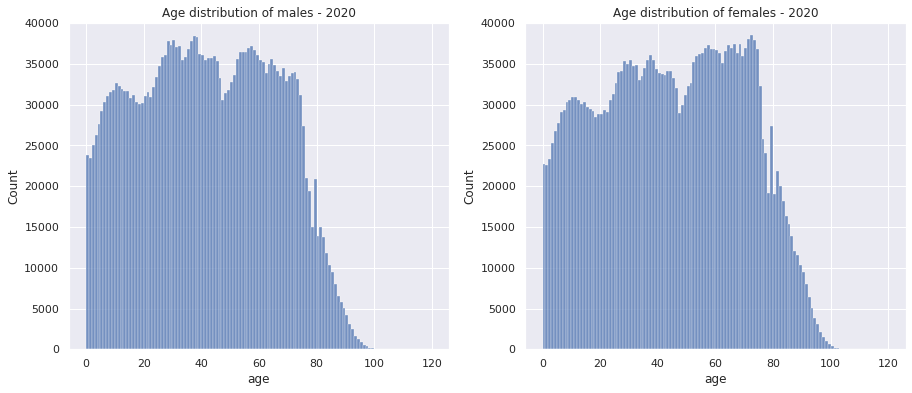

In [6]:
plot_population_age_distributions_by_sex(stats_population_df, title_year=2020, save_with_filename="age_by_sex_distribution_2020.png")

### Lifetime stats by age and sex

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

In [7]:
stats_lifetime_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '002_12ag_2020_20220318-232408.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_lifetime_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'dead_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'dead_count', 'age']), 1)
    return df

stats_lifetime_df = tilastokeskus_transform_lifetime_dataframe(stats_lifetime_df)

stats_lifetime_df.head()

,age,dead_count,sex
0,0,49,1
1,1,5,1
2,2,2,1
3,3,3,1
4,4,5,1


In [8]:
def plot_lifetime_distributions_by_sex(df, title_year=2020):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(data=males, x=males['age'], weights=males['dead_count'], binwidth=1, ax=ax[0])
    mp.set_title(f"Lifetime distribution of males - {title_year}")
    fp = sns.histplot(data=females, x=females['age'], weights=females['dead_count'], binwidth=1, ax=ax[1])
    fp.set_title(f"Lifetime distribution of females - {title_year}")
    fig.show()

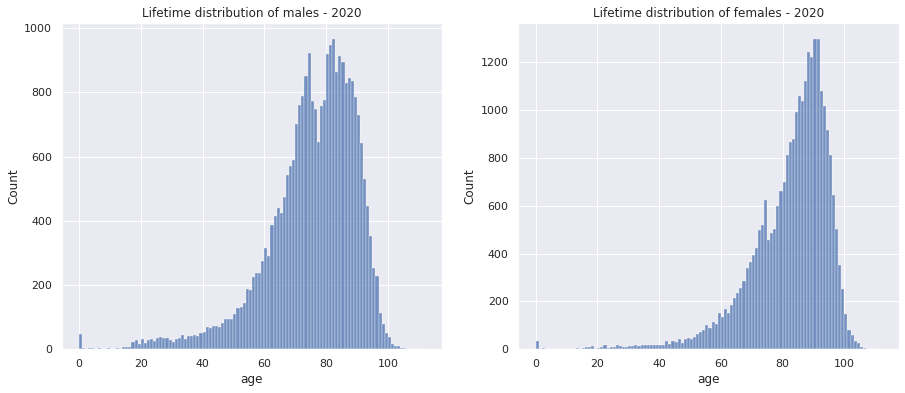

In [9]:
plot_lifetime_distributions_by_sex(stats_lifetime_df)

### Risk of death stats by age and sex

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

In [10]:
stats_death_risk_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '008_12ap_2020_20220321-001345.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_deathrisk_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'death_probability', 'Ikä': 'age'})
    df['death_probability'] = df['death_probability'].apply(pd.to_numeric, errors='coerce')
    df['death_probability'] = df['death_probability'] / 1000
    df = df.drop(df.columns.difference(['sex', 'death_probability', 'age']), 1)
    df = df.dropna()
    return df

stats_death_risk_df = tilastokeskus_transform_deathrisk_dataframe(stats_death_risk_df)

stats_death_risk_df.head()

,age,death_probability,sex
0,0,0.00206,1
1,1,0.00020,1
2,2,0.00008,1
3,3,0.00011,1
4,4,0.00018,1


In [11]:
def plot_risk_of_death_distributions_by_sex(df):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['death_probability'], binrange=(males['age'].min(), males['age'].max() + 1), binwidth=1, ax=ax[0])
    mp.set_title("Death risk of males - 2020")
    ax[0].set(ylabel='probability')
    fp = sns.histplot(x=females['age'], weights=females['death_probability'], binrange=(females['age'].min(), females['age'].max() + 1), binwidth=1, ax=ax[1])
    fp.set_title("Death risk of females - 2020")
    ax[1].set(ylabel='probability')
    fig.show()

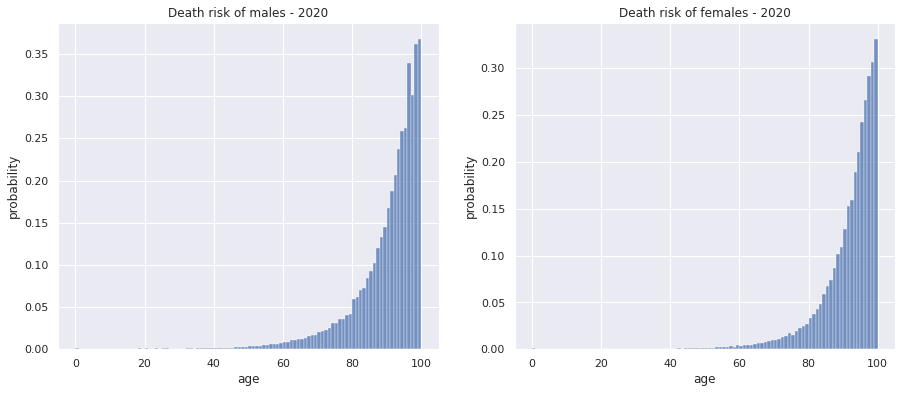

In [12]:
plot_risk_of_death_distributions_by_sex(stats_death_risk_df)

To support vectorized operations we create dictionary with key combined of sex and age. Because during 2020 there were no deaths on every old age up to max age (=120) we prefill those ages' death risk as equal with given greatest death age. We also make sure that death occurs for sure in the simulation at the age of simulation max age (=120) to make simulation reasonable and well behaving.

In [13]:
SEX_AGE_INDEX_GAP = 1000

assert SEX_AGE_INDEX_GAP > Cfg.MAX_AGE

# Sex and age to index value
def get_sex_age_index_value(sex, age):
    return sex * SEX_AGE_INDEX_GAP + age

# Inverse for get_sex_age_index_value
def sex_and_age_from_index_value(sex_age_index_value):
    return (int(sex_age_index_value >= SEX_AGE_INDEX_GAP), sex_age_index_value % SEX_AGE_INDEX_GAP)


death_probability_by_sex_and_age_index = {}
death_probability_by_sex_and_age = {0: {}, 1: {}}
for _, row in stats_death_risk_df.iterrows():
    death_probability_by_sex_and_age[row['sex']][row['age']] = row['death_probability']

# TODO this is simple prefill assuming death risk is constant after -> use increasing death risk
for sex in Cfg.SEXES:
    given_max_age = int(max(death_probability_by_sex_and_age[sex].keys()))
    for age in range(given_max_age + 1, Cfg.MAX_AGE + 1):
        death_probability_by_sex_and_age[sex][age] =  death_probability_by_sex_and_age[sex][given_max_age]
    # Let's make sure that there is upper limit for the age
    death_probability_by_sex_and_age[sex][Cfg.MAX_AGE] = 1

for sex in death_probability_by_sex_and_age:
    for age in death_probability_by_sex_and_age[sex]:
        death_probability_by_sex_and_age_index[get_sex_age_index_value(sex, age)] = death_probability_by_sex_and_age[sex][age]

### Fertility stats

Birth rate simulation uses following statistics using year 2020:  
StatFin / Population / Births / 12dm -- Live births by sex, birth order and age of mother (1-year), 1990-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__synt/statfin_synt_pxt_12dm.px/table/tableViewLayout1/

Here we make following simplifications:

1. If range given for mother age is like 0-14 then we simplify that all mothers have age of 14.
2. If range given for mother age is like 55- then we simplify that all mothers have age of 55.
3. This concludes that in this case ages 0-13 and 55+ have zero fertility rate.

In [14]:
stats_fertility_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '005_12dm_2020_20220318-232741.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_fertility_dataframe(df, population_df):
    def transform_mother_age(age_str):
        if age_str.isnumeric():
            return int(age_str)
        if '-' in age_str:
            lowest_age_in_range_str = age_str.split('-')[0].strip()
            biggest_age_in_range_str = age_str.split('-')[-1].strip()
            if biggest_age_in_range_str:
                return transform_mother_age(biggest_age_in_range_str)
            elif lowest_age_in_range_str:
                return transform_mother_age(lowest_age_in_range_str)
        raise ValueError(f"Cannot parse age out of {age_str}")
    
    def apply_female_population_count_by_row(row):
        population_count = population_df[(population_df['sex'] == 0) & (population_df['age'] == row['mother_age'])]['population_count']
        assert len(population_count) == 1
        population_count = population_count.iloc[0]
        return population_count
        
    df['mother_age'] = df['Äidin ikä'].apply(transform_mother_age)
    
    df['total_number_of_children_born'] = df['Miehet Elävänä syntyneet'] + df['Naiset Elävänä syntyneet']
    df = df.drop(df.columns.difference(['mother_age', 'total_number_of_children_born']), 1)
    df = df.dropna()
    
    df['female_population_count'] = df.apply(apply_female_population_count_by_row, axis=1)
    df['birth_probability'] = df['total_number_of_children_born'] / df['female_population_count']
    
    return df

stats_fertility_df = tilastokeskus_transform_fertility_dataframe(stats_fertility_df, stats_population_df)

stats_fertility_df.head()

,mother_age,total_number_of_children_born,female_population_count,birth_probability
0,14,3,30315,0.000099
1,15,9,29699,0.000303
2,16,28,29525,0.000948
3,17,59,29203,0.002020
4,18,162,28480,0.005688


In [15]:
# Babies born in 2020
print(f"Babies born in {Cfg.INITIAL_YEAR}: {stats_fertility_df['total_number_of_children_born'].sum()}")

Babies born in 2020: 46463


Create birth probability index for vectorized operations

In [16]:
birth_probability_by_age = {}
for _, row in stats_fertility_df.iterrows():
    birth_probability_by_age[row['mother_age']] = row['birth_probability']

for age in range(0, Cfg.MAX_AGE + 1):
    if age not in birth_probability_by_age:
        birth_probability_by_age[age] = 0

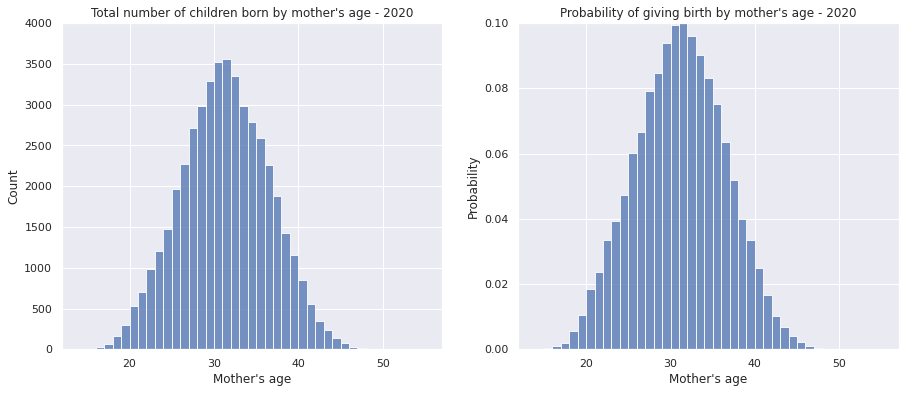

In [17]:
GRAPHICS_FERTILITY_HIST_YLIM = 4000
GRAPHICS_FERTILITY_PROBABILITY_HIST_YLIM = 0.1

def plot_fertility_df_from_simulation_df(df):
    plot_fertility_df = df[df['current_simulation_year_gave_birth'].fillna(False)].groupby(["age"]).agg({'birth_probability': 'mean', 'current_simulation_year_gave_birth': 'count'}).copy()
    plot_fertility_df.reset_index(inplace=True)
    plot_fertility_df = plot_fertility_df.rename(columns = {'age':'mother_age', 'current_simulation_year_gave_birth': 'total_number_of_children_born'})
    
    return plot_fertility_df


def plot_fertility_by_age(df, title_year, save_with_filename=None):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    
    ax[0].set_ylim(top=GRAPHICS_FERTILITY_HIST_YLIM)
    ax[1].set_ylim(top=GRAPHICS_FERTILITY_PROBABILITY_HIST_YLIM)
        
    histogram1 = sns.histplot(x=df['mother_age'], weights=df['total_number_of_children_born'], binrange=(14, 55), binwidth=1, ax=ax[0])
    histogram1.set_title(f"Total number of children born by mother's age - {title_year}")
    histogram1.set(xlabel="Mother's age")
    histogram1.set(ylabel="Count")
    
    histogram2 = sns.histplot(x=df['mother_age'], weights=df['birth_probability'], binrange=(14, 55), binwidth=1, ax=ax[1])
    histogram2.set_title(f"Probability of giving birth by mother's age - {title_year}")
    histogram2.set(xlabel="Mother's age")
    histogram2.set(ylabel="Probability")
    
    if save_with_filename:
        filepath = os.path.join(Cfg.IMAGE_DIR, save_with_filename)
        if os.path.exists(filepath) and not Cfg.OVERWRITE_IMAGES:
            raise Exception(f"Image {save_with_filename} already exists")
        plt.savefig(filepath)
    
    
plot_fertility_by_age(stats_fertility_df, title_year=Cfg.INITIAL_YEAR)

### Initialize simulation population

In [18]:
def create_initial_population(stats_population_df):
    initialization_population_size = math.ceil(stats_population_df['population_count'].sum() * Cfg.INITIAL_POPULATION_SIZE_SCALE_FACTOR)
    
    ages = np.zeros(initialization_population_size, dtype=int)
    sexes = np.zeros(initialization_population_size, dtype=int)
    year_of_birth = np.zeros(initialization_population_size, dtype=int)
    # This is artificial index so that we can utilize vectorized operations for the dataframe (millions of rows are too slow without vectorization)
    sex_age_index = np.zeros(initialization_population_size, dtype=int)

    start_idx = 0
    for _, row in stats_population_df.iterrows():
        simulation_count = math.floor(row['population_count'] * Cfg.INITIAL_POPULATION_SIZE_SCALE_FACTOR)
        end_idx = start_idx + simulation_count
        ages[start_idx:end_idx] = np.repeat(row['age'], simulation_count)
        sexes[start_idx:end_idx] = np.repeat(row['sex'], simulation_count)
        year_of_birth[start_idx:end_idx] = np.repeat(Cfg.INITIAL_YEAR - row['age'], simulation_count)
        sex_age_index[start_idx:end_idx] = np.repeat(get_sex_age_index_value(row['sex'], row['age']), simulation_count)
        start_idx = end_idx
    
    if initialization_population_size != end_idx:
        ages = ages[:end_idx]
        sexes = sexes[:end_idx]
        year_of_birth = year_of_birth[:end_idx]
        sex_age_index = sex_age_index[:end_idx]

    df = pd.DataFrame({'age': ages, 'sex': sexes, 'year_of_birth': year_of_birth, 'sex_age_index': sex_age_index})
    dead_df = pd.DataFrame().reindex(columns=df.columns)
    dead_df['death_year'] = pd.Series([], dtype=int)
    
    return df, dead_df

df, dead_df = create_initial_population(stats_population_df)

max_people_in_sex_age_group = df.groupby(['sex','age']).size().max()
if max_people_in_sex_age_group <= 5000:
    GRAPHICS_POPULATION_HIST_YLIM = int(math.ceil(max_people_in_sex_age_group / 100.0)) * 100
elif max_people_in_sex_age_group > 5000 and max_people_in_sex_age_group <= 15000:
    GRAPHICS_POPULATION_HIST_YLIM = int(math.ceil(max_people_in_sex_age_group / 1000.0)) * 1000
else:
    GRAPHICS_POPULATION_HIST_YLIM = int(math.ceil(max_people_in_sex_age_group / 5000.0)) * 5000
    

# This is just approximation for graphics to keep histogram y-limit constant
max_babies_per_mother_age_group = math.ceil(df[df['sex'] == 0].groupby(['age']).size().max() * max(birth_probability_by_age.values()))
if max_babies_per_mother_age_group <= 100:
    GRAPHICS_FERTILITY_HIST_YLIM = int(math.ceil(max_babies_per_mother_age_group / 10.0)) * 10
else:
    GRAPHICS_FERTILITY_HIST_YLIM = int(math.ceil(max_babies_per_mother_age_group / 100.0)) * 100
    
initial_population_size = len(df)
    
print(f"Initial population size for simulation based on year {Cfg.INITIAL_YEAR}: {initial_population_size}")

Initial population size for simulation based on year 2020: 5533793


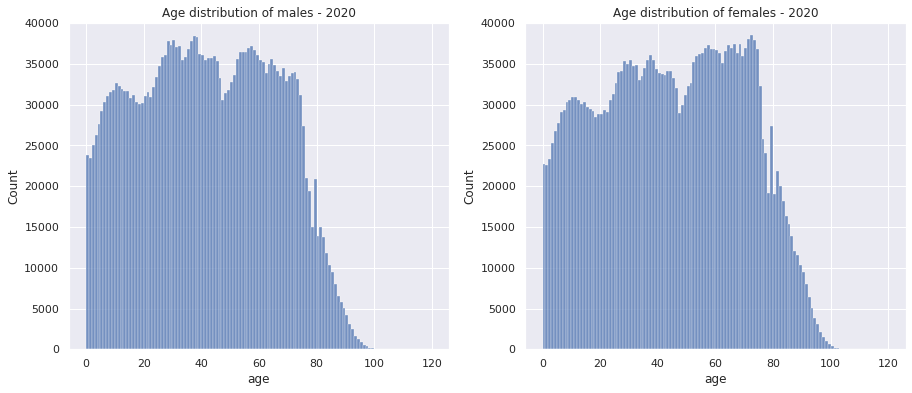

In [19]:
plot_population_age_distributions_by_sex(df, title_year=2020, aggregated=False)

## Simulation

In [20]:
def simulate_one_year(df, dead_df, year):
    df['random'] = np.random.random(len(df))
    # Get conditional probability of death conditioned on sex
    df['death_probability'] = df['sex_age_index'].map(lambda idx_value: death_probability_by_sex_and_age_index[idx_value])
    dead = df.loc[df['random'] < df['death_probability'], :].copy()
    dead['death_year'] = year
    dead_df = dead_df.append(dead, ignore_index=True)
    df.drop(dead.index, inplace=True)
    # Update ages and related indexes and probabilities
    df['age'] += 1
    df['sex_age_index'] += 1
    
    df['random'] = np.random.random(len(df))
    # Get conditional probability of giving birth conditioned on age
    df['birth_probability'] = df.loc[df['sex'] == 0]['age'].apply(lambda age: birth_probability_by_age[age])
    # Fill zero for males
    df['birth_probability'] = df['birth_probability'].fillna(0)
    df['current_simulation_year_gave_birth'] = df['random'] < df['birth_probability']
    
    newborn_count = len(df[df['current_simulation_year_gave_birth']])
    ages = np.zeros(newborn_count, dtype=int)
    sexes = np.zeros(newborn_count, dtype=int)
    year_of_birth = np.repeat(year, newborn_count)
    sex_age_index = np.zeros(newborn_count, dtype=int)
    newborn_males_index = round(newborn_count * Cfg.MALE_BIRTH_PROBABILITY)
    sexes[:newborn_males_index] = 1
    sex_age_index[:newborn_males_index] = get_sex_age_index_value(1, 0)
    sex_age_index[newborn_males_index:] = get_sex_age_index_value(0, 0)

    newborn_df = pd.DataFrame({'age': ages, 'sex': sexes, 'year_of_birth': year_of_birth, 'sex_age_index': sex_age_index})
    # TODO this resets index - newborn_df index should be adjusted by starting from max+1 of the df index
    df = pd.concat([df, newborn_df], ignore_index=True)
    
    return df, dead_df


def simulate_until(target_year, df, dead_df):
    results = {'population_development': {
        Cfg.INITIAL_YEAR: {
            'total': len(df),
            'males': len(df[df['sex'] == 1]),
            'females': len(df[df['sex'] == 0])
        }
    }}
    for year in range(Cfg.INITIAL_YEAR + 1, target_year + 1):
        # Set fixed seed for the year
        np.random.seed(year)
        df, dead_df = simulate_one_year(df, dead_df, year)
        results['population_development'][year] = {
            'total': len(df),
            'males': len(df[df['sex'] == 1]),
            'females': len(df[df['sex'] == 0])
        }
        if 'POPULATION_COUNT_BY_AGE_AND_SEX' in Cfg.SIMULATION_GRAPHICS:
            plot_population_age_distributions_by_sex(df, title_year=year, aggregated=False, save_with_filename=f'age_by_sex_distribution_{year}.png')
        if 'FERTILITY_BY_AGE' in Cfg.SIMULATION_GRAPHICS:
            plot_fertility_df = plot_fertility_df_from_simulation_df(df)
            plot_fertility_by_age(plot_fertility_df, title_year=year, save_with_filename=f'fertility_by_age_distribution_{year}.png')
            
    return df, dead_df, results

In [21]:
# We do not show all intermediate graphs so let's not plot them
%matplotlib agg

# Cfg.INITIAL_POPULATION_SIZE_SCALE_FACTOR = 0.01
# Cfg.TARGET_YEAR = 2100

assert Cfg.INITIAL_YEAR == 2020
assert Cfg.TARGET_YEAR > Cfg.INITIAL_YEAR

# Create initial population df and df for dead
df, dead_df = create_initial_population(stats_population_df)
initial_population_size = len(df)

plot_population_age_distributions_by_sex(df, title_year=2020, aggregated=False, save_with_filename="age_by_sex_distribution_2020.png")

# Run simulation
df, dead_df, results = simulate_until(Cfg.TARGET_YEAR, df, dead_df)

# Animate results
if 'POPULATION_COUNT_BY_AGE_AND_SEX' in Cfg.SIMULATION_GRAPHICS:
    animate_gif([f'age_by_sex_distribution_{year}.png' for year in range(Cfg.INITIAL_YEAR, Cfg.TARGET_YEAR + 1)], 'age_by_sex_distribution_animation.gif')
if 'FERTILITY_BY_AGE' in Cfg.SIMULATION_GRAPHICS:
    animate_gif([f'fertility_by_age_distribution_{year}.png' for year in range(Cfg.INITIAL_YEAR + 1, Cfg.TARGET_YEAR + 1)], 'fertility_by_age_distribution_animation.gif')

# Put back inline plotting
%matplotlib inline

/mnt/c/Users/OMISTAJA/code/masters-degree/population-simulation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


## Results of the simulation

### Animation of population distribution over time
![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=7)

### Animation of newborn and fertility over time

![Animated age by sex over simulations](../images/fertility_by_age_distribution_animation.gif?q=7)

### Development of population over time

In [22]:
def plot_population_development(results):
    data = results['population_development']
    # TODO this is global I guess? If so move elsewhere
    sns.set(rc={'figure.figsize':(15, 6)})
    years = list(data.keys())
    totals = [data[year]['total'] for year in data]
    males = [data[year]['males'] for year in data]
    females = [data[year]['females'] for year in data]
    plot_df = pd.DataFrame({'year': years, 'total': totals, 'males': males, 'females': females})
    g = sns.lineplot(data=pd.melt(plot_df, ['year']), x='year', y='value', hue='variable')
    plt.xticks(years, rotation=45)
    
    number_of_digits = len(str(initial_population_size)) - 1
    ylim = math.ceil(initial_population_size/(10**number_of_digits))*10**number_of_digits
    plt.ylim(0, ylim)

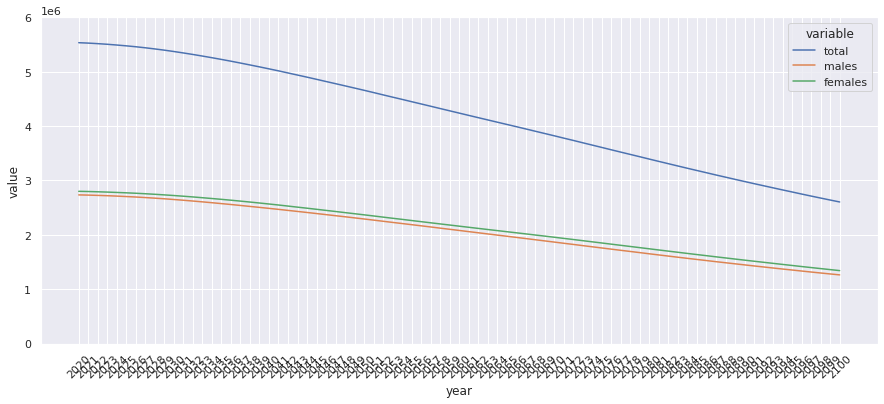

In [23]:
plot_population_development(results)

### Life expectancy analysis

#### What is life expectancy?

Quoting [Wikipedia](https://en.wikipedia.org/wiki/Life_expectancy): "Life expectancy is a statistical measure of the average time an organism is expected to live, based on the year of its birth, its current age, and other demographic factors like sex. The most commonly used measure is life expectancy at birth (LEB), which can be defined in two ways. Cohort LEB is the mean length of life of a birth cohort (all individuals born in a given year) and can be computed only for cohorts born so long ago that all their members have died. Period LEB is the mean length of life of a hypothetical cohort assumed to be exposed, from birth through death, to the mortality rates observed at a given year."

So there are (at least) two ways to calculate life expectancy:

1. **Cohort life expectancy** is average life length of particular cohort. Here cohort means population born in specific year. Cohort life expectancy is a bit challenging in practice since all the people in the cohort must have died before beeing able to calculate it. Cohort life expectancy tend to be greater than period life expectancy (see below) due to development of healthcare etc.
2. **Period life expectancy** is estimation where hypothethical cohort are exposed to mortality rates on specific time period. Usually when we talk about life expectancy we mean period life expectancy and most statistics mean period life expectancy when using just the word life expectancy. Period life expectancy tend to be lower than actual cohort ("empirical") life expectancy.

Advantage of the simulation is that we can actually calculate cohort life expectancy. In this simulation model though, cohort life expectancy and period life expectancy are equal because risk of death has been modelled as a constant over time.

But if we update the model so that the death risk evolves over time then the simulation would provide different results for cohort life expectancy and period life expectancy and be used as a demonstration of the differences. E.g. model where death risk distribution would take "steps to the right" over time would demostrate that cohort life expectancy would be greater than period life expectancy.

In [24]:
def simulate_until_cohort_dead(df, dead_df, cohort_year_of_birth):
    cohort_df = df[df['year_of_birth'] == cohort_year_of_birth].copy()
    cohort_dead_df = dead_df[dead_df['year_of_birth'] == cohort_year_of_birth].copy()
    cohort_target_year = Cfg.TARGET_YEAR
    while len(cohort_df[cohort_df['year_of_birth'] == cohort_year_of_birth]) > 0:
        cohort_target_year += 1
        cohort_df, cohort_dead_df = simulate_one_year(cohort_df, cohort_dead_df, cohort_target_year)
    
    return cohort_dead_df[cohort_dead_df['year_of_birth'] == cohort_year_of_birth].copy(), cohort_target_year


life_expectancy_cohort_year = 2020
cohort_dead_df, cohort_simulation_end_year = simulate_until_cohort_dead(df, dead_df, life_expectancy_cohort_year)

### A pinch of artificial complexity

To demonstrate law of large numbers we do following:

1. Kernel density estimate (KDE) distribution of death ages on given cohort
2.Sample from kernel density estimated distribution
3. Use sample from the step 2 to Monte Carlo estimate lifetime expectancy on given year.

Why do we do it in so complicated way? Just to demonstrate KDE and law of large numbers.

We can calculate easily the ground truth simply by taking mean of the cohort death ages groupped by sex (shown below):

In [25]:
life_expectancy_cohort_females = cohort_dead_df[cohort_dead_df['sex'] == 0]['age'].mean()
print(f"Cohort ({life_expectancy_cohort_year}) life expectancy for females: {round(life_expectancy_cohort_females, 1)}")
life_expectancy_cohort_males = cohort_dead_df[cohort_dead_df['sex'] == 1]['age'].mean()
print(f"Cohort ({life_expectancy_cohort_year}) life expectancy for males: {round(life_expectancy_cohort_males, 1)}")

Cohort (2020) life expectancy for females: 84.1
Cohort (2020) life expectancy for males: 78.7


That was simple. Now let's do the same in a comlicated and approximative way.

#### Gaussian kernel density estimation of the death age distribution

Kernel density estimation is a non-parametric method for estimating density function of a distribution.

$$
\begin{gather}
\textrm{Let }x_1, x_2, ..., x_n\textrm{ be an i.i.d sample from the unknown distribution }f(x).\newline
\textrm{Now kernel density estimator }\hat{f}(x)\textrm{ of the distribution }f(x)\textrm{ is defined as:}\newline
\hat{f}(x)=\frac{1}{nh}\sum_{i=1}^{n} K(\frac{x - x_i}{h})\newline
\textrm{where }K \textrm{ is the kernel function and }h > 0\textrm{ is a smoothing parameter.}\newline
\textrm{Kernel function must satisfy}\newline
\int_{-\infty}^{\infty}K(x)dx=1\newline
\textrm{Gaussian kernel is defined as:}\newline
K(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
\end{gather}
$$

Here we choose $h = 1$ as a smoothing parameter value because it feels quite natural for the age and seems to produce reasonable results. Kernel density estimation distribution can be seen from the figure below on the top right corner (e.g. "KDE for original 2021 distribution").

#### Law of large numbers demonstration

Strong law of large numbers states that

$$
\begin{gather}
\textrm{Let }\mu=\mathbb {E}(X)\textrm{ then}\newline
\overline{X}_{n}\xrightarrow{\text{a.s.}} \mu \qquad {\textrm {when}}\ n\to \infty\newline
\end{gather}
$$

Now we want to estimate the life expectancy given sex and cohort year $\mathbb {E}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})$.

We previously showed a method for approximating density function of a distribution with kernel density estimation. Now it is reasonable to approximate death age distribution given cohort year and sex $f(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})$ with continuous KDE estimate $\hat{f}_{KDE}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})$.

$$
\begin{gather}
\textrm{Now}\newline
f(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth}) \approx \hat{f_{KDE}}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})\newline
\textrm{Let }\hat{X_i} \sim \hat{f_{KDE}}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})\qquad i.i.d\newline
\textrm{Now because}\newline
\mathbb {E}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})=\int_{0}^{max\ age}x\ f(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth})dx\newline
\textrm{We can approximate age of death distribution with KDE estimated distribution and utilize} \newline \textrm{strong law of large numbers to Monte Carlo approximate conditional expectation by sampling the KDE distribution}\newline
\mathbb {E}(X_{age\ of\ death}|X_{sex},X_{year\ of\ birth}) \approx \sum_{i=1}^{n} x_{i,age\ of\ death} \hat{f_{KDE}}(x_{i, age\ of\ death}|x_{i,sex},X_{year\ of\ birth})
\end{gather}
 $$

Results of the Monte Carlo approximate traceplot we can see from the bottom right corner of the figure below (e.g. "Traceplot for 2021 life expectancy Monte Carlo estimation"). We see that the estimate of the lifetime expectancy converges as n increases.

In [26]:
def kde_distribution(data):
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(data.reshape(-1, 1))
    
    return kde


def plot_kde(kde, ax, title):
    data_grid = np.linspace(0, Cfg.MAX_AGE, 1000)
    logprob = kde.score_samples(data_grid.reshape(-1, 1))
    prob = np.exp(logprob)
    mp = ax.fill_between(data_grid.reshape(-1), prob, alpha=0.3)
    ax.set_title(title)

    
def sample_from_kde(kde, n=1000):
    return kde.sample(n, random_state=42).reshape(-1)


def plot_histogram_of_ages(samples, ax, title):
    mp = sns.histplot(samples, binrange=(0, Cfg.MAX_AGE + 1), binwidth=1, ax=ax)
    mp.set_title(title)
    ax.set(ylabel='Count')
    ax.set(xlabel='Age')

    
def plot_monte_carlo_life_expectancy(samples, ax, title):
    idx = np.arange(1, len(samples) + 1)
    mcle_cumsum = np.cumsum(samples) / idx
    mp = sns.lineplot(x=idx, y=mcle_cumsum, ax=ax)
    estimated_life_expectancy = mcle_cumsum[-1]
    mp.set_title(title + f"\n Estimated lifetime expectancy {round(estimated_life_expectancy, 1)}")
    
    return round(estimated_life_expectancy, 1)


def life_expectancy_analysis(year, sex):
    fig, ax = plt.subplots(2, 2, figsize=(Cfg.A4_DIMS[0], Cfg.A4_DIMS[1]*2))
    death_age_data = cohort_dead_df[cohort_dead_df['sex'] == sex]['age'].to_numpy()
    plot_histogram_of_ages(death_age_data, ax[0, 0], f"Original simulated cohort {year} distribution")
    death_age_kde = kde_distribution(death_age_data)
    plot_kde(death_age_kde, ax[0, 1], f"KDE for original cohort {year} distribution")
    death_age_samples = sample_from_kde(death_age_kde)

    plot_histogram_of_ages(death_age_samples, ax[1, 0], title=f"Samples from cohort {year} KDE")
    plot_monte_carlo_life_expectancy(death_age_samples, ax[1, 1], f"Traceplot for {year} life expectancy Monte Carlo estimation")

#### Lifetime expectancy for cohort born in 2020

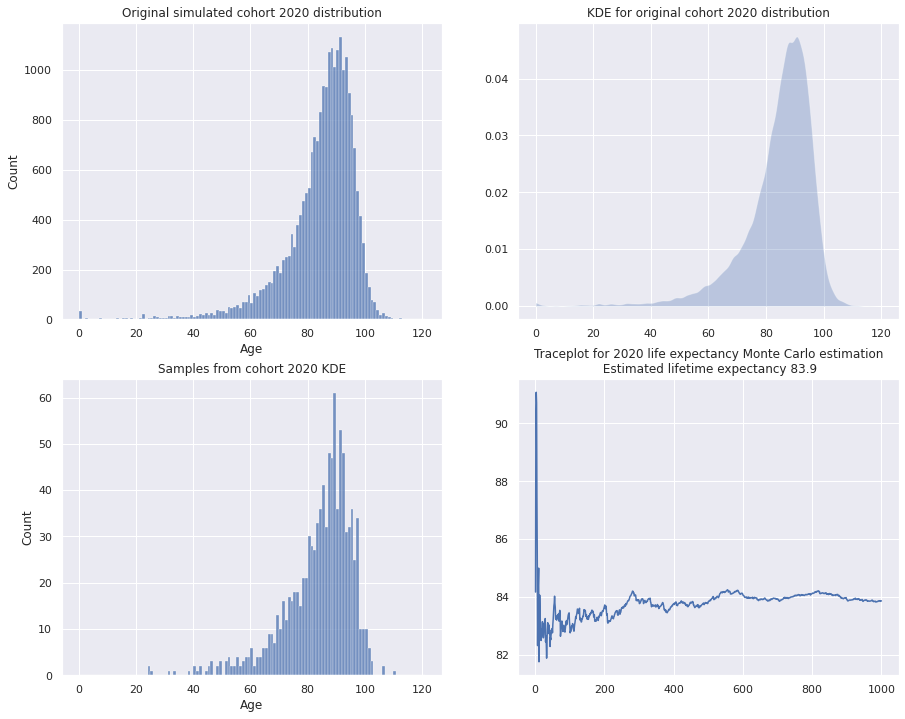

In [27]:
# Females
life_expectancy_analysis(life_expectancy_cohort_year, 0)

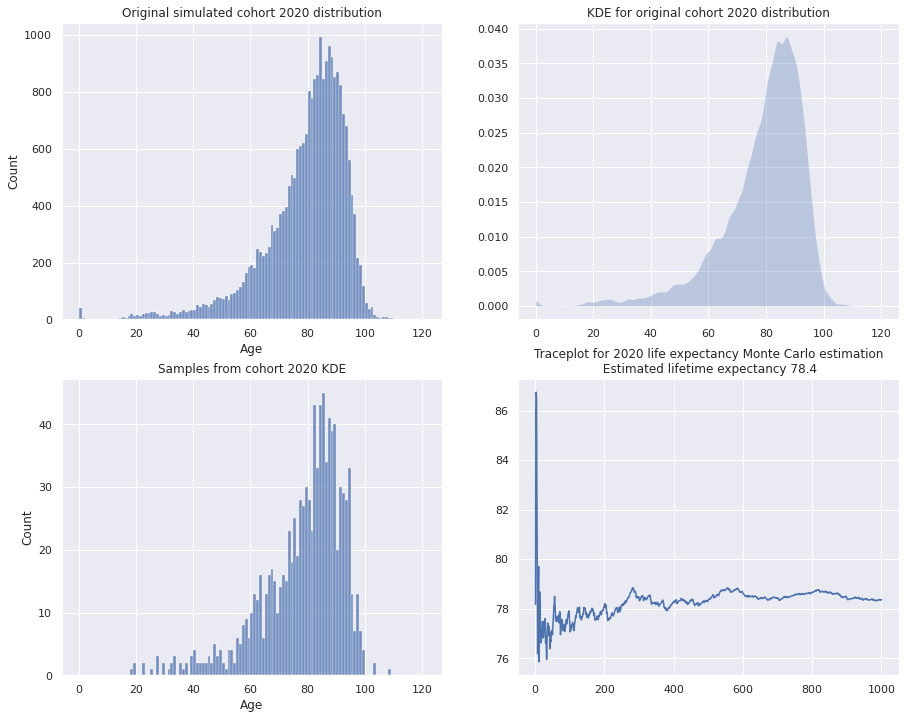

In [28]:
# Males
life_expectancy_analysis(life_expectancy_cohort_year, 1)

#### Comparison to statistics Finland official estimate of the lifetime expectancy

Statistics Finland [official lifetime expectancy for 2020](https://www.stat.fi/til/kuol/2020/01/kuol_2020_01_2021-10-22_tie_001_en.html) states that "Average life expectancy at birth was exactly 79 years for boys and 84.6 years for girls in 2020". This is **quite well inline** with the results shown above.